# Imports

# Global settings

# Data split load

# Localization

In [9]:
import pytorch_lightning as pl
# your favorite machine learning tracking tool
from pytorch_lightning.loggers import WandbLogger


In [8]:
import numpy as np
import random
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from torchmetrics.classification import AUROC,AveragePrecision
import torchmetrics
from sklearn.metrics import roc_curve, auc
import os
from sklearn.model_selection import train_test_split
import shutil
from copy import deepcopy
from tqdm import tqdm
from matplotlib import pyplot as plt

In [10]:
class BrainDataModule(pl.LightningDataModule):
    def __init__(self, batch_size, data_dir: str = './'):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        self.transform_train = transforms.Compose([
                                        transforms.Resize((256,256)),
                                       transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomAffine(5,translate=[0,.1],scale=[.9,1.1]),
                                      transforms.ToTensor(),
                                      transforms.Normalize( mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225])
                                      
                                     ])
        self.transform = transforms.Compose([
            transforms.Resize((256,256)),

            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225])
        ])
        
        self.num_classes = 4
    
    def setup(self, stage=None):
        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
                self.train = ImageFolder(self.data_dir+"/train",
                                    transform=self.transform_train,
                                )

                self.val = ImageFolder(self.data_dir+"/val",
                                    transform=self.transform,
                                )

                


        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.test = ImageFolder(self.data_dir+"/test",
                                    transform=self.transform,)
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True)


    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size)


    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size)



In [11]:
transform = transforms.Compose([
            transforms.Resize((224,224)),

            transforms.ToTensor(),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

In [12]:
from pytorch_lightning.callbacks import  Callback
from torch import  nn
from torch.nn import  functional as F

In [13]:
from torchvision.models import resnet34

In [14]:
class LitModel(pl.LightningModule):
    def __init__(self, input_shape, num_classes, learning_rate=2e-4):
        super().__init__()
        
        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.model_pretrain=resnet34(weights='IMAGENET1K_V1')
        self.model_pretrain.fc=nn.Linear(512,num_classes)
        self.accuracy=torchmetrics.Accuracy(task="multiclass", num_classes=4)
    # returns the feature tensor from the conv block
  
    
    # will be used during inference
    def forward(self, x):
       x=self.model_pretrain(x)
       return F.softmax( x,dim=1)
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # training metrics
        preds = logits
        acc = self.accuracy(preds, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, logger=True)
        
        return loss
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)


        # validation metrics
        preds = logits
        acc = self.accuracy(preds, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        
        # validation metrics
        preds = logits
        acc = self.accuracy(preds, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer


In [12]:
dm = BrainDataModule(batch_size=4,data_dir="Dataset")

In [13]:
dm.setup()
batch=dm.val_dataloader()

In [14]:
val_samples = next(iter(batch))
val_imgs, val_labels = val_samples[0], val_samples[1]
val_imgs.shape, val_labels.shape


(torch.Size([4, 3, 256, 256]), torch.Size([4]))

In [15]:
test_samples = next(iter(dm.test_dataloader()))
test_imgs, test_labels = test_samples[0], test_samples[1]
test_imgs.shape, test_labels.shape


(torch.Size([4, 3, 256, 256]), torch.Size([4]))

In [12]:
class ImagePredictionLogger(Callback):
    def __init__(self, val_samples, num_samples=32):
        super().__init__()
        self.num_samples = num_samples
        self.val_imgs, self.val_labels = val_samples
        self.test_imgs, self.test_labels=test_samples
    def on_validation_epoch_end(self, trainer, pl_module):
        # Bring the tensors to CPU
        val_imgs = self.val_imgs.to(device=pl_module.device)
        val_labels = self.val_labels.to(device=pl_module.device)
        # Get model prediction
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        # Log the images as wandb Image
        trainer.logger.experiment.log({
            "examples":[wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            })
    def on_test_epoch_end(self, trainer, pl_module):
        # Bring the tensors to CPU
        val_imgs = self.test_imgs.to(device=pl_module.device)
        val_labels = self.test_labels.to(device=pl_module.device)
        # Get model prediction
        logits = pl_module(val_imgs)
        preds = torch.argmax(logits, -1)
        # Log the images as wandb Image
        trainer.logger.experiment.log({
            "Test_examples":[wandb.Image(x, caption=f"Pred:{pred}, Label:{y}") 
                           for x, pred, y in zip(val_imgs[:self.num_samples], 
                                                 preds[:self.num_samples], 
                                                 val_labels[:self.num_samples])]
            })


In [1]:
# import wandb
# wandb.init(project="brain")


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nguyenxuanloc-official. Use `wandb login --relogin` to force relogin


In [15]:
from pytorch_lightning.callbacks import EarlyStopping,ModelCheckpoint


In [14]:
early_stop_callback=EarlyStopping(monitor="val_loss",min_delta=3e-4,verbose=2)
checkpoint_callback=ModelCheckpoint(
     monitor='val_loss',dirpath="model",save_last=True

)


In [18]:
# model = LitModel(3, dm.num_classes)


# # Initialize wandb logger
# wandb_logger = WandbLogger(project='wandb-lightning', job_type='train')

# # Initialize a trainer
# trainer = pl.Trainer(max_epochs=3,
#                      logger=wandb_logger,
#                      callbacks=[early_stop_callback, ImagePredictionLogger(val_samples),checkpoint_callback])

# # # # Lúc huấn luyện thì tắt note 3 dòng bên dưới
# # # # Train the model ⚡🚅⚡
# trainer.fit(model, dm)


# # # # Evaluate the model on the held-out test set ⚡⚡

# trainer.test(dataloaders=dm.test_dataloader()),
# # # # Close wandb run
# wandb.finish()
model = LitModel(3, dm.num_classes)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=10, callbacks=[early_stop_callback, checkpoint_callback])

# Train the model
trainer.fit(model, dm)

# Evaluate the model on the held-out test set
trainer.test(dataloaders=dm.test_dataloader())


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\nguye\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:612: UserWarning: Checkpoint directory G:\DeepLearning\Model\model exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params
------------------------------------------------------
0 | model_pretrain | ResNet             | 21.3 M
1 | accuracy       | MulticlassAccuracy | 0     
------------------------------------------------------
21.3 M    Trainable params
0         Non-trainable params
21.3 M    Total params
85.147    Total estimated model params size (MB)


Sanity Checking DataLoader 0:  50%|█████     | 1/2 [00:00<00:00, 26.10it/s]

c:\Users\nguye\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


c:\Users\nguye\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|██████████| 542/542 [01:19<00:00,  6.85it/s, v_num=3, val_loss=1.010, val_acc=0.722]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.909. Signaling Trainer to stop.


Epoch 0: 100%|██████████| 542/542 [01:19<00:00,  6.85it/s, v_num=3, val_loss=1.010, val_acc=0.722]


c:\Users\nguye\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at G:\DeepLearning\Model\model\epoch=2-step=1626.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at G:\DeepLearning\Model\model\epoch=2-step=1626.ckpt
c:\Users\nguye\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the numb

Testing DataLoader 0: 100%|██████████| 156/156 [00:07<00:00, 19.66it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.7926045060157776     │
│         test_loss         │    0.9421793818473816     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.9421793818473816, 'test_acc': 0.7926045060157776}]

In [16]:
bestmodel=LitModel.load_from_checkpoint("G:\DeepLearning\Model\model\epoch=2-step=1626.ckpt")
bestmodel.eval()

LitModel(
  (model_pretrain): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [20]:
transform = transforms.Compose([
            transforms.Resize((256,256)),

            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225])
        ])

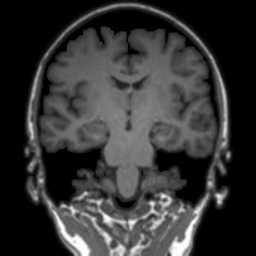

In [21]:
from PIL import Image
# img = Image.open(r"G:\BrainTumor\Dataset\test\glioma_tumor\G_9.jpg")
img = Image.open(r"G:\DeepLearning\Model\Dataset\test\normal\N_4.jpg")
# img = Image.open(r"G:\DeepLearning\Model\Dataset\test\meningioma_tumor\M_15.jpg")
img

In [23]:
import torch

# Kiểm tra xem CUDA có sẵn hay không
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chuyển đổi dữ liệu vào thiết bị tính toán (CPU hoặc CUDA)
inputdata = transform(img).to(device)

# Thêm một chiều mới và chuyển đổi tensor sang GPU (nếu có sẵn)
inputdata = inputdata.unsqueeze(0).to(device)

# In ra kích thước của tensor
print(inputdata.shape)


torch.Size([1, 3, 256, 256])


In [24]:
logits=bestmodel(inputdata)
preds = torch.argmax(logits, -1)


In [25]:
classname={0:"glioma_tumor", 1:"meningioma_tumor", 2:"normal_tumor", 3:"pituitary_tumor"}


In [26]:
classname[int(preds.cpu().numpy())]

'normal_tumor'

In [27]:
import tkinter as tk
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import webbrowser

class TumorClassifierApp:
    def __init__(self, master):
        self.master = master
        self.master.title("Brain Tumor Classifier")

        self.img_path = None
        self.url = ""  # Biến để lưu trữ URL của dự đoán

        # Thiết lập màu sắc
        self.main_color = "#4CAF50"
        self.hover_color = "#45a049"
        self.font_color = "white"

        # Khung chính
        self.main_frame = tk.Frame(self.master, bg="white")
        self.main_frame.pack(expand=True, fill="both")

        # Tiêu đề
        self.title_label = tk.Label(self.main_frame, text="Brain Tumor Classifier", font=("Helvetica", 18, "bold"), bg="white")
        self.title_label.pack(pady=10)

        # Nút chọn ảnh
        self.choose_btn = tk.Button(self.main_frame, text="Choose Image", command=self.choose_image, bg=self.main_color, fg=self.font_color, font=("Helvetica", 12), padx=10, pady=5)
        self.choose_btn.pack(pady=10)
        self.choose_btn.bind("<Enter>", lambda event: self.choose_btn.config(bg=self.hover_color))
        self.choose_btn.bind("<Leave>", lambda event: self.choose_btn.config(bg=self.main_color))

        # Hiển thị ảnh
        self.default_image_path = "G:\\DeepLearning\\Model\\default.png"  # Đường dẫn đến ảnh mặc định
        self.default_image = Image.open(self.default_image_path)
        self.default_image = self.default_image.resize((250, 250), Image.ANTIALIAS)
        self.default_image = ImageTk.PhotoImage(self.default_image)
        self.panel = tk.Label(self.main_frame, image=self.default_image, bg="white")
        self.panel.pack(padx=20, pady=10)

        # Kết quả dự đoán
        self.result_label = tk.Label(self.main_frame, text="", font=("Helvetica", 14), bg="white")
        self.result_label.pack(pady=5)

        # URL thông tin và điều trị
        self.url_label = tk.Label(self.main_frame, text="", font=("Helvetica", 12), fg="blue", cursor="hand2", bg="white")
        self.url_label.pack(pady=5)
        self.url_label.bind("<Button-1>", self.open_url)

        # Nút dự đoán
        self.predict_btn = tk.Button(self.main_frame, text="Predict", command=self.predict, bg=self.main_color, fg=self.font_color, font=("Helvetica", 12), padx=10, pady=5)
        self.predict_btn.pack(pady=10)
        self.predict_btn.bind("<Enter>", lambda event: self.predict_btn.config(bg=self.hover_color))
        self.predict_btn.bind("<Leave>", lambda event: self.predict_btn.config(bg=self.main_color))

        # Danh sách các URL cho mỗi lớp dự đoán
        self.url_list = {
            "glioma_tumor": "https://s.net.vn/GEWn",
            "meningioma_tumor": "https://s.net.vn/GUiy",
            "normal_tumor": "https://s.net.vn/lCnh",
            "pituitary_tumor": "https://s.net.vn/jf3k"
        }

        # Đặt kích thước cố định cho cửa sổ
        self.master.geometry("400x550")

    def choose_image(self):
        self.img_path = filedialog.askopenfilename()
        self.url = ""  # Xóa URL khi chọn ảnh mới
        if self.img_path:
            img = Image.open(self.img_path)
            img = img.resize((250, 250), Image.ANTIALIAS)
            img = ImageTk.PhotoImage(img)
            self.panel.configure(image=img)
            self.panel.image = img
            self.result_label.config(text="")
            self.url_label.config(text="")  # Ẩn URL khi chọn ảnh mới

    def predict(self):
        if self.img_path:
            img = Image.open(self.img_path)
            inputdata = transform(img).to(device)
            inputdata = inputdata.unsqueeze(0).to(device)
            logits = bestmodel(inputdata)
            preds = torch.argmax(logits, -1)
            predicted_class = classname[int(preds.cpu().numpy())]
            self.url = self.url_list.get(predicted_class, "https://s.net.vn/CjOR")  # Lưu trữ URL tương ứng với lớp dự đoán
            result_text = f"Disease prediction: {predicted_class}"
            self.result_label.config(text=result_text)
            self.url_label.config(text="Information and treatment", fg="blue")
        else:
            messagebox.showerror("Error", "Please choose an image first.")

    def open_url(self, event):
        if self.url:
            webbrowser.open(self.url)

def main():
    root = tk.Tk()
    app = TumorClassifierApp(root)
    root.mainloop()

if __name__ == "__main__":
    main()


C:\Users\nguye\AppData\Local\Temp\ipykernel_19300\2764459341.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  self.default_image = self.default_image.resize((250, 250), Image.ANTIALIAS)
C:\Users\nguye\AppData\Local\Temp\ipykernel_19300\2764459341.py:72: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((250, 250), Image.ANTIALIAS)
